### App Reviews 

Dataset: https://www.kaggle.com/datasets/souravghosh01/google-play-store-app-reviews-categorized?resource=download

Variables:
- reviewId : Unique ID of the reviewer
- userName: UserName of the reviewer
- userImage: Google account profile picture associated with the reviewer
- content: the review of the app
- score: the corresponding rating of the review 
- thumbsUpcount: Number of helpful votes 
- appId: unique application ID that looks like a Java package name
- category: App belonging to the category.

In [1]:
!pip install tensorflow_text
!pip install transformers

import os
import re
import time
import string
import numpy as np 
import pandas as pd 
import seaborn as sns
from itertools import groupby
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from transformers import pipeline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 36.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully u

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv("sf_review.csv")

In [3]:
# Dimenzionalita datasetu
df.shape

(55744, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55744 entries, 0 to 55743
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              55744 non-null  object
 1   userName              55742 non-null  object
 2   userImage             55744 non-null  object
 3   content               55740 non-null  object
 4   score                 55744 non-null  int64 
 5   thumbsUpCount         55744 non-null  int64 
 6   reviewCreatedVersion  47013 non-null  object
 7   at                    55744 non-null  object
 8   replyContent          12921 non-null  object
 9   repliedAt             12921 non-null  object
 10  sortOrder             55744 non-null  object
 11  appId                 55744 non-null  object
 12  category              55744 non-null  object
dtypes: int64(2), object(11)
memory usage: 5.5+ MB


In [5]:
# Deskriptivní statistika číselných atributů
df.describe()

,score,thumbsUpCount
count,55744.000000,55744.000000
mean,3.017473,35.181813
std,1.311262,448.157062
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,5.000000
max,5.000000,56126.000000


In [6]:
# Identifikace chybějících hodnot 
df.isnull().sum()

reviewId                    0
userName                    2
userImage                   0
content                     4
score                       0
thumbsUpCount               0
reviewCreatedVersion     8731
at                          0
replyContent            42823
repliedAt               42823
sortOrder                   0
appId                       0
category                    0
dtype: int64

In [7]:
# Odstranění nepotřebných atributů
df = df.drop(columns = ['reviewId', 
                        'userName', 
                        'userImage', 
                        'reviewCreatedVersion', 
                        'at', 
                        'replyContent',
                        'repliedAt'])

In [8]:
# Identifikace indexů pozorování, u nichž není k dispozici žádný komentář, aby se tyto mezery dále doplnily. 
nan_content = df['content'].isna()
index_of_nan = []
for i in range(len(nan_content)):
    if nan_content[i] == True:
        index_of_nan.append(i)

# Doplnění chybějících hodnot      
for i, v in enumerate(index_of_nan):
    df['content'][v] = "xxx"

<ipython-input-8-f66b35ad4f10>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'][v] = "xxx"


#### Analýza sentimentu

In [9]:
# 499 mb
Twitter_roBERTa = pipeline(
    task = 'text-classification', 
    model = "cardiffnlp/twitter-roberta-base-sentiment", 
    top_k = None)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [10]:
# vyhledávání tokenů nad 500 znaků
num_of_tokens = []

for i in range(len(df['content'])):
    num_of_tokens.append(len(Twitter_roBERTa.tokenizer(df['content'][i]).get('input_ids')))
    
# Nahrazení pozorování s nesrozumitelnými znaky (jejich tokeny jsou vyšší než 500)
len_tokens = []
indexes = []
for i in range(len(num_of_tokens)):
    if num_of_tokens[i] >= 500:
        indexes.append(i)
        len_tokens.append(num_of_tokens[i])

print(len_tokens)
print(indexes)    

[700, 573, 685, 614, 554, 514, 514, 574, 547, 570, 539, 801, 793, 899]
[6697, 17258, 20503, 21748, 24744, 35082, 40823, 47464, 49343, 53332, 53686, 53708, 54245, 54499]


In [11]:
# příklad
df['content'][54245]

'Nnnj🤣ൻ ñjñ❤nnnnuhnnjjñnjnn❤🤣nuunnhjninnnjnjjñnnnunnj ññnnu👍nnunnñന്നന്ന ജ്ജ്ന്ന് ജ്ജ്ഹ്നഹ്ഞ്ഞ്ഞ്ണ്ണുന്നഹജ്ന്നിണ് ñയൂ ñൻ nñനമ്പർ ñഉണ്ടോ ñnnnnhjnnhnnnn🌹nñunnnnnnnnnhujjnnh🙏nnjjnnjnñ😃ñjnñ😀ന്ന 😃hn😀ന്നുജനഞ്ഞ്ഞുൺ ജ്ഞാന്നന്നന്നന്ന ഉജ് nnñനന്നന് 😅ñഉമ്മ unnnñunnn nnñജ്ഞാൻ ñnnnnnñന്ന ñഇഞ്ഞി ñ😃ññnñh😀nnjn👏nnñjñ👏ñജന് ñഉണ്ണിഞ്ഞ്ഞ്ഞ്ഞ് നിന്ന്ജ njnjñnnjñഞാൻ ñnnjn😃ñññjnjhhnjjnjnñണിഞ്ഞ് nñnjnnnn nnnnjnn hnnnn ജ്ജ്ജ്ജ് ñunnnnn😃hñjhjnnh😀😃ഉന്നഹൻഹജ്ജുന്നഹജ്ന്ന് nhjjññyjnujnuunnunjunhnnñഞജെൻ hunjjnñj'

In [12]:
# nahrazení těchto znaků
for i, v in enumerate(indexes):
    df['content'][v] = "xxx"

<ipython-input-12-0b330dd64320>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'][v] = "xxx"


#### Aplikace modelu

In [13]:
start = time.time() 

results = []
for i in range(len(df["content"])):
    iter = time.time()
    results.append(Twitter_roBERTa(df["content"][i], top_k = True))
    end_iter = time.time() - iter
    print(f'iter:{i} from 55744;  timeof 1 iter:{round(end_iter, 2)}')

end = time.time() - start 

print(f'Exicutive time is: {round(end, 2)}')

Выходные данные были обрезаны до нескольких последних строк (5000).
iter:50745 from 55744;  timeof 1 iter:0.14
iter:50746 from 55744;  timeof 1 iter:0.17
iter:50747 from 55744;  timeof 1 iter:0.13
iter:50748 from 55744;  timeof 1 iter:0.38
iter:50749 from 55744;  timeof 1 iter:0.37
iter:50750 from 55744;  timeof 1 iter:0.39
iter:50751 from 55744;  timeof 1 iter:0.13
iter:50752 from 55744;  timeof 1 iter:0.32
iter:50753 from 55744;  timeof 1 iter:0.32
iter:50754 from 55744;  timeof 1 iter:0.45
iter:50755 from 55744;  timeof 1 iter:0.28
iter:50756 from 55744;  timeof 1 iter:0.35
iter:50757 from 55744;  timeof 1 iter:0.36
iter:50758 from 55744;  timeof 1 iter:0.22
iter:50759 from 55744;  timeof 1 iter:0.19
iter:50760 from 55744;  timeof 1 iter:0.17
iter:50761 from 55744;  timeof 1 iter:0.27
iter:50762 from 55744;  timeof 1 iter:0.23
iter:50763 from 55744;  timeof 1 iter:0.15
iter:50764 from 55744;  timeof 1 iter:0.23
iter:50765 from 55744;  timeof 1 iter:0.15
iter:50766 from 55744;  timeo

In [14]:
df['sentiment'] = results

In [29]:
for i, value in enumerate(df['sentiment']):
    if df['sentiment'][i][0].get('label') == 'LABEL_0':
        df['sentiment'][i] = 'Negative'
    elif df['sentiment'][i][0].get('label') == 'LABEL_1':
        df['sentiment'][i] = 'Neutral'
    else: df['sentiment'][i] = 'Positive'

<ipython-input-29-69d60d39f2c7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'][i] = 'Negative'
<ipython-input-29-69d60d39f2c7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: df['sentiment'][i] = 'Positive'
<ipython-input-29-69d60d39f2c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'][i] = 'Neutral'


In [30]:
y = []
for i, value in enumerate(df["sentiment"].unique()):
        y.append(df["sentiment"].value_counts()[value])

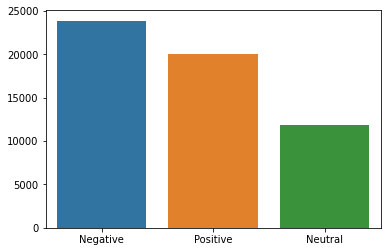

In [31]:
sns.barplot(data = df, x = df['sentiment'].unique(), y = y)
plt.show()

In [32]:
df.head(3)

,content,score,thumbsUpCount,sortOrder,appId,category,sentiment
0,Earlier it was used to be good but now it's be...,1,83,most_relevant,org.videolan.vlc,videoplayer,Negative
1,This will be the best video player in Android ...,1,65,most_relevant,org.videolan.vlc,videoplayer,Positive
2,Before it was perfectly stable now its all gon...,1,56,most_relevant,org.videolan.vlc,videoplayer,Negative


In [34]:
df.to_csv('df_sentiment.csv', index=False)

## Classification

In [2]:
df = pd.read_csv("df_sentiment.csv")

In [3]:
trained_model = tf.keras.models.load_model('сlassification_model_0.3')

Pro demonstraci toho, jak náš natrénovaný model funguje, použijeme pro klasifikaci pouze 1 % dat. 

In [4]:
short_dataset = df.sample(frac = 0.01, random_state = 42)

In [5]:
print(short_dataset.shape)

(557, 7)


In [6]:
short_dataset.head()

,content,score,thumbsUpCount,sortOrder,appId,category,sentiment
53957,"Yep, Another App to plug up my phone. This app...",3,21,newest,com.sec.android.app.sbrowser,browsers,"[{'label': 'LABEL_0', 'score': 0.7393997907638..."
33239,This app needs a lot of Improvements. Doesn't ...,2,0,most_relevant,org.thoughtcrime.securesms,communication,"[{'label': 'LABEL_2', 'score': 0.6465387940406..."
31630,its a great app i had started using this app n...,5,166,most_relevant,com.bharatpe.app,payment,"[{'label': 'LABEL_2', 'score': 0.9820978045463..."
40488,Viber message notifications are stealing sound...,2,5,newest,com.viber.voip,communication,"[{'label': 'LABEL_0', 'score': 0.9332249760627..."
24891,विश्वास.....,4,0,newest,in.org.npci.upiapp,payment,"[{'label': 'LABEL_1', 'score': 0.7685685157775..."


#### Odstranění duplicit

In [7]:
# Odstranění duplicit, pokud se slova v komentáři vyskytují více než 2krát.
def remove_duplicates(text_before):
    my_dict = dict()
    text_after = list()
    for word in text_before.split():
        if word not in my_dict.keys():
            my_dict[word] = 1
        else:
            my_dict[word] = my_dict[word] + 1
    
    for key, value in my_dict.items():
        if value>=2:
            text_after.append(key)
        else:
            text_after.append(key)
    return " ".join(text_after)

In [8]:
short_dataset['comment_text_clean'] = short_dataset['content'].apply(lambda text : remove_duplicates(text))

#### Délka komentářů

In [9]:
# délka komentářů
#train['comment_text_len'] = train['comment_text_clean'].apply(lambda x : len(x.split())) 

short_dataset['comment_len'] = short_dataset['comment_text_clean'].str.len()
fig = px.histogram(short_dataset, x = 'comment_len',
                   title='Histogram of len of comments',
                   labels={'Number of samples, len of comments'},
                   opacity = 0.8,
                   log_y=True,
                   color_discrete_sequence = ['blue'])
fig.show()

#### Čištění textů

In [10]:
def clean_text(text):
    """Make text lowercase, remove text in square brackets, remove links
    and remove stop words containing numbers"""
    text = text.lower()                                            # Converts the text to lowercase using regex 
    text = re.sub(r"\[.*?\]","",text)                              # Replace's the text into 'nothing" if text is present inside squre brackets.
    text = re.sub("https?://\S+|www\.\S+","",text)                 # Removes the links from the comments.
    text = re.sub("<.*?>+","",text)                                # Remove unwanted
    text = re.sub("\n","",text)                                    # Remove next line symbols '\n'
    text = re.sub("\w*\d\w*","",text)                              # Takes only albhabet and digits.
    return text
short_dataset['comment_text_clean'] = short_dataset['comment_text_clean'].apply(lambda text : clean_text(text))

#### Odstranění stop slov
Stop slova jsou často používaná slova, která nepřidávají do textu žádné další informace. Slova jako "the", "is", "a" nemají žádnou hodnotu a pouze přidávají do dat šum.

In [11]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
short_dataset['comment_text_clean'] = short_dataset['comment_text_clean'].apply(remove_stopwords)

#### Stemming
Wikipedie:  
"[Stematizace](https://cs.wikipedia.org/wiki/Stematizace) (anglicky stemming) je nalezení kmene slova (nepřesně a úžeji taky kořene). Algoritmus se nazývá stemmer. V praxi se stematizace používá například ve vyhledávačích, kde dovoluje vyhledávat bez ohledu na konkrétní tvar. Podobnou operaci lematizace provádí lemmatizátor – tato operace vrací základní tvar slova (tj. lemma) místo kmene)."

Alternativním přístupem je lemmatizace.

In [12]:
# Stemming the texts
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

short_dataset['comment_text_clean'] = short_dataset['comment_text_clean'].apply(stemm_text)

In [13]:
# Model predictions
model_predictions = trained_model.predict([short_dataset['comment_text_clean']])

18/18 [==============================] - 189s 10s/step


In [14]:
short_dataset[['pred_CONTENT', 'pred_INTERFACE', 'pred_SUBSCRIPTION', 'pred_USER_EXPERIENCE']] = model_predictions
short_dataset['predicted_category'] = 0

In [16]:
for i in range(len(short_dataset)):
    max_val = short_dataset.iloc[:, 9:12][i:(1+i)].max().max()
    if (short_dataset['pred_CONTENT'][i:(1+i)] == max_val).any():
        short_dataset['predicted_category'][i:(i+1)] = 'CONTENT'
    if (short_dataset['pred_INTERFACE'][i:(1+i)] == max_val).any():
        short_dataset['predicted_category'][i:(i+1)] = 'INTERFACE'
    if (short_dataset['pred_SUBSCRIPTION'][i:(1+i)] == max_val).any():
        short_dataset['predicted_category'][i:(i+1)] = 'SUBSCRIPTION'
    if (short_dataset['pred_USER_EXPERIENCE'][i:(1+i)] == max_val).any():
        short_dataset['predicted_category'][i:(i+1)] = 'USER_EXPERIENCE'

<ipython-input-16-333c8f7c42a2>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
short_dataset.head(3)

,content,score,thumbsUpCount,sortOrder,appId,category,sentiment,comment_text_clean,comment_len,pred_CONTENT,pred_INTERFACE,pred_SUBSCRIPTION,pred_USER_EXPERIENCE,predicted_category
53957,"Yep, Another App to plug up my phone. This app...",3,21,newest,com.sec.android.app.sbrowser,browsers,"[{'label': 'LABEL_0', 'score': 0.7393997907638...","yep, anoth app plug phone. app updat yr. tell ...",129,0.266122,0.334703,0.127277,0.234643,INTERFACE
33239,This app needs a lot of Improvements. Doesn't ...,2,0,most_relevant,org.thoughtcrime.securesms,communication,"[{'label': 'LABEL_2', 'score': 0.6465387940406...",app need lot improvements. show person onlin o...,299,0.298460,0.611027,0.160384,0.075808,INTERFACE
31630,its a great app i had started using this app n...,5,166,most_relevant,com.bharatpe.app,payment,"[{'label': 'LABEL_2', 'score': 0.9820978045463...",great app start use n realli make busi receiv ...,257,0.344567,0.557169,0.135935,0.108076,INTERFACE
